## Competição DSA 2019/03
<h3>Prever vendas das Farmácias Solar</h3>

Fazendo as importações necessárias (bibliotecas e arquivos)

In [1]:
# Importar as bibliotecas necessárias para este notebook
import pandas as pd
import numpy  as np
from datetime import datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# importar os arquivos para dataframes:
train_file = pd.read_csv('dataset_treino.csv')
test_file  = pd.read_csv('dataset_teste.csv')
store_file = pd.read_csv('lojas.csv')

/home/angelo/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Entender os dados

In [3]:
# Visualiar primeiras linhas dos arquivos:
train_file.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
train_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [5]:
test_file.head(10)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
5,6,10,4,2015-09-17,1.0,1,0,0
6,7,11,4,2015-09-17,1.0,1,0,0
7,8,12,4,2015-09-17,1.0,1,0,0
8,9,13,4,2015-09-17,1.0,1,0,0
9,10,14,4,2015-09-17,1.0,1,0,0


In [6]:
test_file.Date.describe()

count          41088
unique            48
top       2015-08-13
freq             856
Name: Date, dtype: object

In [7]:
test_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [8]:
store_file.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
store_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


Tratar valores NaN

In [10]:
train_file.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [11]:
test_file.isna().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [12]:
store_file.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [13]:
# DataFrame de treino possui a variável Customers
# estas não estão presentes no dataFrame de testes, assim, serão excluídas
train_file.drop(['Customers'], axis=1, inplace = True); train_file.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,1,1,0,1
1,2,5,2015-07-31,6064,1,1,0,1
2,3,5,2015-07-31,8314,1,1,0,1
3,4,5,2015-07-31,13995,1,1,0,1
4,5,5,2015-07-31,4822,1,1,0,1


In [14]:
# DataFrame test_file possui a coluna Open (indicador loja aberta: 0 = fechada, 1 = aberta)
# Substituir NaN por 0
test_file.Open.fillna(0, inplace = True); test_file.isna().sum()

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [15]:
# DataFrame store_file possui diversas colunas NaN. Entender caso a caso.
# Primeiro, e menor caso, CompetitionDistance com apenas 3 ocorrências,
# substituir pela média
store_file.CompetitionDistance.fillna(store_file.CompetitionDistance.mean(), inplace = True); store_file.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [16]:
# Segundo caso, variável CompetitionOpenSinceMonth (mês aproximado em que o concorrente mais próximo foi aberto)
print(store_file.CompetitionOpenSinceMonth.describe())
# Substituir os valores NaN pelo mínimo
store_file.CompetitionOpenSinceMonth.fillna(store_file.CompetitionOpenSinceMonth.min(), inplace = True); store_file.isna().sum()

count    761.000000
mean       7.224704
std        3.212348
min        1.000000
25%        4.000000
50%        8.000000
75%       10.000000
max       12.000000
Name: CompetitionOpenSinceMonth, dtype: float64


Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [17]:
# Terceiro caso, variável CompetitionOpenSinceYear
print(store_file.CompetitionOpenSinceYear.describe())
# Substituir NaN pelo mínimo
store_file.CompetitionOpenSinceYear.fillna(store_file.CompetitionOpenSinceYear.min(), inplace = True); store_file.isna().sum()

count     761.000000
mean     2008.668857
std         6.195983
min      1900.000000
25%      2006.000000
50%      2010.000000
75%      2013.000000
max      2015.000000
Name: CompetitionOpenSinceYear, dtype: float64


Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [18]:
# Quarto caso, variável Promo2SinceWeek (descreve a semana do calendário em que a loja começou a participar do Promo2)
print(store_file.Promo2SinceWeek.describe())
print(store_file.Promo2SinceWeek.unique())
# Esta variável tem relação com a Promo2 (promoção contínua: 0 = loja não está participando, 1 = loja está participando)
# Identificar o range de valores de Promo2 onde Promo2SinceWeek é NaN
store_file[store_file['Promo2SinceWeek'].isnull()]['Promo2'].describe()
# Substituir NaN por zero
store_file.Promo2SinceWeek.fillna(0, inplace = True); store_file.isna().sum()

count    571.000000
mean      23.595447
std       14.141984
min        1.000000
25%       13.000000
50%       22.000000
75%       37.000000
max       50.000000
Name: Promo2SinceWeek, dtype: float64
[nan 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.]


Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [19]:
# Quinto caso, variável Promo2SinceYear (descreve o ano do calendário em que a loja começou a participar do Promo2)
print(store_file.Promo2SinceYear.describe())
print(store_file.Promo2SinceYear.unique())
# Esta variável tem relação com a Promo2 (promoção contínua: 0 = loja não está participando, 1 = loja está participando)
# Identificar o range de valores de Promo2 onde Promo2SinceWeek é NaN
store_file[store_file['Promo2SinceYear'].isnull()]['Promo2'].describe()
# Substituir NaN por zero
store_file.Promo2SinceYear.fillna(0, inplace = True); store_file.isna().sum()

count     571.000000
mean     2011.763573
std         1.674935
min      2009.000000
25%      2011.000000
50%      2012.000000
75%      2013.000000
max      2015.000000
Name: Promo2SinceYear, dtype: float64
[  nan 2010. 2011. 2012. 2009. 2014. 2015. 2013.]


Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                544
dtype: int64

In [20]:
# Sexto caso, variável PromoInterval (intervalos consecutivos onde Promo2 é iniciado)
print(store_file.PromoInterval.describe())
print(store_file.PromoInterval.unique())
# Esta variável tem relação com a Promo2 (promoção contínua: 0 = loja não está participando, 1 = loja está participando)
# Identificar o range de valores de Promo2 onde Promo2SinceWeek é NaN
store_file[store_file['PromoInterval'].isnull()]['Promo2'].describe()
# Substituir NaN por zero
store_file.PromoInterval.fillna(0, inplace = True); store_file.isna().sum()

count                 571
unique                  3
top       Jan,Apr,Jul,Oct
freq                  335
Name: PromoInterval, dtype: object
[nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [21]:
# Alterar variáveis para int
store_file.CompetitionOpenSinceMonth = store_file.CompetitionOpenSinceMonth.astype('int64')
store_file.CompetitionOpenSinceYear  = store_file.CompetitionOpenSinceYear.astype('int64')
store_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1115 non-null float64
CompetitionOpenSinceMonth    1115 non-null int64
CompetitionOpenSinceYear     1115 non-null int64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null float64
Promo2SinceYear              1115 non-null float64
PromoInterval                1115 non-null object
dtypes: float64(3), int64(4), object(3)
memory usage: 87.2+ KB


In [22]:
# Criar variável do tipo datetime
store_file['CompetitionOpenYMD'] = pd.to_datetime(store_file.CompetitionOpenSinceYear.astype(str) + '/' + store_file.CompetitionOpenSinceMonth.astype(str) + '/01')

In [23]:
# Com isso, as variáveis CompetitionOpenSinceYear e CompetitionOpenSinceMonth podem ser apagadas
store_file.drop(['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'], axis=1, inplace = True)

In [24]:
store_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 9 columns):
Store                  1115 non-null int64
StoreType              1115 non-null object
Assortment             1115 non-null object
CompetitionDistance    1115 non-null float64
Promo2                 1115 non-null int64
Promo2SinceWeek        1115 non-null float64
Promo2SinceYear        1115 non-null float64
PromoInterval          1115 non-null object
CompetitionOpenYMD     1115 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 78.5+ KB


In [25]:
store_file.head()

,Store,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenYMD
0,1,c,a,1270.0,0,0.0,0.0,0,2008-09-01
1,2,a,a,570.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2007-11-01
2,3,a,a,14130.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2006-12-01
3,4,c,c,620.0,0,0.0,0.0,0,2009-09-01
4,5,a,a,29910.0,0,0.0,0.0,0,2015-04-01


In [26]:
# Alterar os valores de StoreType e Assortment para int
store_file.StoreType  = store_file.StoreType.map({'a': 1, 'b': 2, 'c': 3, 'd': 4})
store_file.Assortment = store_file.Assortment.map({'a': 1, 'b': 2, 'c': 3, 'd': 4})
print(store_file.info())
store_file.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 9 columns):
Store                  1115 non-null int64
StoreType              1115 non-null int64
Assortment             1115 non-null int64
CompetitionDistance    1115 non-null float64
Promo2                 1115 non-null int64
Promo2SinceWeek        1115 non-null float64
Promo2SinceYear        1115 non-null float64
PromoInterval          1115 non-null object
CompetitionOpenYMD     1115 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(4), object(1)
memory usage: 78.5+ KB
None


,Store,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenYMD
0,1,3,1,1270.0,0,0.0,0.0,0,2008-09-01
1,2,1,1,570.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2007-11-01
2,3,1,1,14130.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2006-12-01
3,4,3,3,620.0,0,0.0,0.0,0,2009-09-01
4,5,1,1,29910.0,0,0.0,0.0,0,2015-04-01


In [27]:
store_file.isna().sum()

Store                  0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
Promo2SinceWeek        0
Promo2SinceYear        0
PromoInterval          0
CompetitionOpenYMD     0
dtype: int64

In [28]:
train_file.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,1,1,0,1
1,2,5,2015-07-31,6064,1,1,0,1
2,3,5,2015-07-31,8314,1,1,0,1
3,4,5,2015-07-31,13995,1,1,0,1
4,5,5,2015-07-31,4822,1,1,0,1


In [29]:
# Criar variável do tipo datetime nos dataframes train_file e test_file
train_file.Date = pd.to_datetime(train_file['Date'], format = "%Y-%m-%d")
test_file.Date  = pd.to_datetime(test_file['Date'], format = "%Y-%m-%d")
# Checar os resultados:
print(train_file["Date"].head())
print(test_file["Date"].head())

0   2015-07-31
1   2015-07-31
2   2015-07-31
3   2015-07-31
4   2015-07-31
Name: Date, dtype: datetime64[ns]
0   2015-09-17
1   2015-09-17
2   2015-09-17
3   2015-09-17
4   2015-09-17
Name: Date, dtype: datetime64[ns]


In [30]:
# Alterar a coluna StateHoliday para boolean
# 0 será False, 1 será True
train_file.StateHoliday  = train_file.StateHoliday!='0'
test_file.StateHoliday   = test_file.StateHoliday!='0'

In [31]:
# Alterar a coluna SchoolHoliday para boolean
train_file.SchoolHoliday = train_file.SchoolHoliday.map({1: True, 0: False})
test_file.SchoolHoliday  = test_file.SchoolHoliday.map({1: True, 0: False})

In [32]:
test_file.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,False,False
1,2,3,4,2015-09-17,1.0,1,False,False
2,3,7,4,2015-09-17,1.0,1,False,False
3,4,8,4,2015-09-17,1.0,1,False,False
4,5,9,4,2015-09-17,1.0,1,False,False


In [33]:
train_file.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,1,1,False,True
1,2,5,2015-07-31,6064,1,1,False,True
2,3,5,2015-07-31,8314,1,1,False,True
3,4,5,2015-07-31,13995,1,1,False,True
4,5,5,2015-07-31,4822,1,1,False,True


In [34]:
# Juntar os dados de store com train_file e test_file
df_train = pd.merge(train_file, store_file, on = 'Store')
df_test  = pd.merge(test_file, store_file,  on = 'Store')

In [35]:
# A função abaixo é de autoria de Lukas e Rich Andrews, usuários do stackoverflow. A eles meu muito obrigado
# Lukas: https://stackoverflow.com/users/10257810/lukas; Rich https://stackoverflow.com/users/9324678/rich-andrews
def matched(row):
    if type(row['PromoInterval'])==str:
        return row['Date'].month in [datetime.strptime(mon.strip()[:3], '%b').month for mon in row['PromoInterval'].split(',')]        
    else:
        # for numbers - return True if months match
        return row['Date'].month==row['PromoInterval']

In [36]:
# Aplicar a função aos dataFrames
df_train['IsItInPromotion'] = df_train.apply(matched, axis=1)
df_test['IsItInPromotion']  = df_test.apply(matched, axis=1)

In [37]:
pd.set_option('display.max_columns', 60)
df_train.head(15)

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenYMD,IsItInPromotion
0,1,5,2015-07-31,5263,1,1,False,True,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
1,1,4,2015-07-30,5020,1,1,False,True,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
2,1,3,2015-07-29,4782,1,1,False,True,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
3,1,2,2015-07-28,5011,1,1,False,True,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
4,1,1,2015-07-27,6102,1,1,False,True,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
5,1,7,2015-07-26,0,0,0,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
6,1,6,2015-07-25,4364,1,0,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
7,1,5,2015-07-24,3706,1,0,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
8,1,4,2015-07-23,3769,1,0,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
9,1,3,2015-07-22,3464,1,0,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False


In [38]:
df_test.head(15)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenYMD,IsItInPromotion
0,1,1,4,2015-09-17,1.0,1,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
1,857,1,3,2015-09-16,1.0,1,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
2,1713,1,2,2015-09-15,1.0,1,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
3,2569,1,1,2015-09-14,1.0,1,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
4,3425,1,7,2015-09-13,0.0,0,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
5,4281,1,6,2015-09-12,1.0,0,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
6,5137,1,5,2015-09-11,1.0,0,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
7,5993,1,4,2015-09-10,1.0,0,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
8,6849,1,3,2015-09-09,1.0,0,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False
9,7705,1,2,2015-09-08,1.0,0,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False


In [39]:
# Criar coluna com diferença entre as datas entre Date e CompetitionOpenYMD
df_train['DifferenceBetweenDates'] = df_train.Date - df_train.CompetitionOpenYMD
df_test['DifferenceBetweenDates']  = df_test.Date  - df_test.CompetitionOpenYMD

In [40]:
# Criar indicadores boolean a partir da coluna Date: IsMonthFinal, IsMonthBegin, IsYearFinal e IsYearBegin
# dataFrame de treino
df_train.loc[(df_train.Date.dt.day    > 20), 'IsMonthFinal'] = True
df_train.loc[(df_train.Date.dt.day   <= 20), 'IsMonthFinal'] = False
df_train.loc[(df_train.Date.dt.day    < 10), 'IsMonthBegin'] = True
df_train.loc[(df_train.Date.dt.day   >= 10), 'IsMonthBegin'] = False
df_train.loc[(df_train.Date.dt.month == 12), 'IsYearFinal']  = True
df_train.loc[(df_train.Date.dt.month  < 12), 'IsYearFinal']  = False
df_train.loc[(df_train.Date.dt.month  == 1), 'IsYearBegin']  = True
df_train.loc[(df_train.Date.dt.month   > 1), 'IsYearBegin']  = False
# dataFrame de teste
df_test.loc[(df_test.Date.dt.day    > 20), 'IsMonthFinal'] = True
df_test.loc[(df_test.Date.dt.day   <= 20), 'IsMonthFinal'] = False
df_test.loc[(df_test.Date.dt.day    < 10), 'IsMonthBegin'] = True
df_test.loc[(df_test.Date.dt.day   >= 10), 'IsMonthBegin'] = False
df_test.loc[(df_test.Date.dt.month == 12), 'IsYearFinal']  = True
df_test.loc[(df_test.Date.dt.month  < 12), 'IsYearFinal']  = False
df_test.loc[(df_test.Date.dt.month  == 1), 'IsYearBegin']  = True
df_test.loc[(df_test.Date.dt.month   > 1), 'IsYearBegin']  = False

In [41]:
# Já que temos o dia da semana em inteiros (DayOfWeek), capturar também o dia do ano
# Na ordem treino e teste:
df_train['DayOfYear'] = df_train.Date.dt.dayofyear
df_test['DayOfYear']  = df_test.Date.dt.dayofyear

In [42]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenYMD,IsItInPromotion,DifferenceBetweenDates,IsMonthFinal,IsMonthBegin,IsYearFinal,IsYearBegin,DayOfYear
0,1,5,2015-07-31,5263,1,1,False,True,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False,2524 days,True,False,False,False,212
1,1,4,2015-07-30,5020,1,1,False,True,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False,2523 days,True,False,False,False,211
2,1,3,2015-07-29,4782,1,1,False,True,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False,2522 days,True,False,False,False,210
3,1,2,2015-07-28,5011,1,1,False,True,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False,2521 days,True,False,False,False,209
4,1,1,2015-07-27,6102,1,1,False,True,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False,2520 days,True,False,False,False,208


In [43]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenYMD,IsItInPromotion,DifferenceBetweenDates,IsMonthFinal,IsMonthBegin,IsYearFinal,IsYearBegin,DayOfYear
0,1,1,4,2015-09-17,1.0,1,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False,2572 days,False,False,False,False,260
1,857,1,3,2015-09-16,1.0,1,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False,2571 days,False,False,False,False,259
2,1713,1,2,2015-09-15,1.0,1,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False,2570 days,False,False,False,False,258
3,2569,1,1,2015-09-14,1.0,1,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False,2569 days,False,False,False,False,257
4,3425,1,7,2015-09-13,0.0,0,False,False,3,1,1270.0,0,0.0,0.0,0,2008-09-01,False,2568 days,False,False,False,False,256


In [44]:
# Com isso, colunas relativas a data podem ser apagadas
df_train.drop(['Date', 'CompetitionOpenYMD'], axis=1, inplace = True)
df_test.drop(['Date', 'CompetitionOpenYMD'], axis=1, inplace = True)

In [45]:
# Alterar a variável DifferenceBetweenDates de Timedelta para int32
df_train.DifferenceBetweenDates = df_train.DifferenceBetweenDates.dt.days.astype('int32')
df_test.DifferenceBetweenDates = df_test.DifferenceBetweenDates.dt.days.astype('int32')

In [46]:
df_train.head()

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,IsItInPromotion,DifferenceBetweenDates,IsMonthFinal,IsMonthBegin,IsYearFinal,IsYearBegin,DayOfYear
0,1,5,5263,1,1,False,True,3,1,1270.0,0,0.0,0.0,0,False,2524,True,False,False,False,212
1,1,4,5020,1,1,False,True,3,1,1270.0,0,0.0,0.0,0,False,2523,True,False,False,False,211
2,1,3,4782,1,1,False,True,3,1,1270.0,0,0.0,0.0,0,False,2522,True,False,False,False,210
3,1,2,5011,1,1,False,True,3,1,1270.0,0,0.0,0.0,0,False,2521,True,False,False,False,209
4,1,1,6102,1,1,False,True,3,1,1270.0,0,0.0,0.0,0,False,2520,True,False,False,False,208


Dados tratados, começa a modelagem

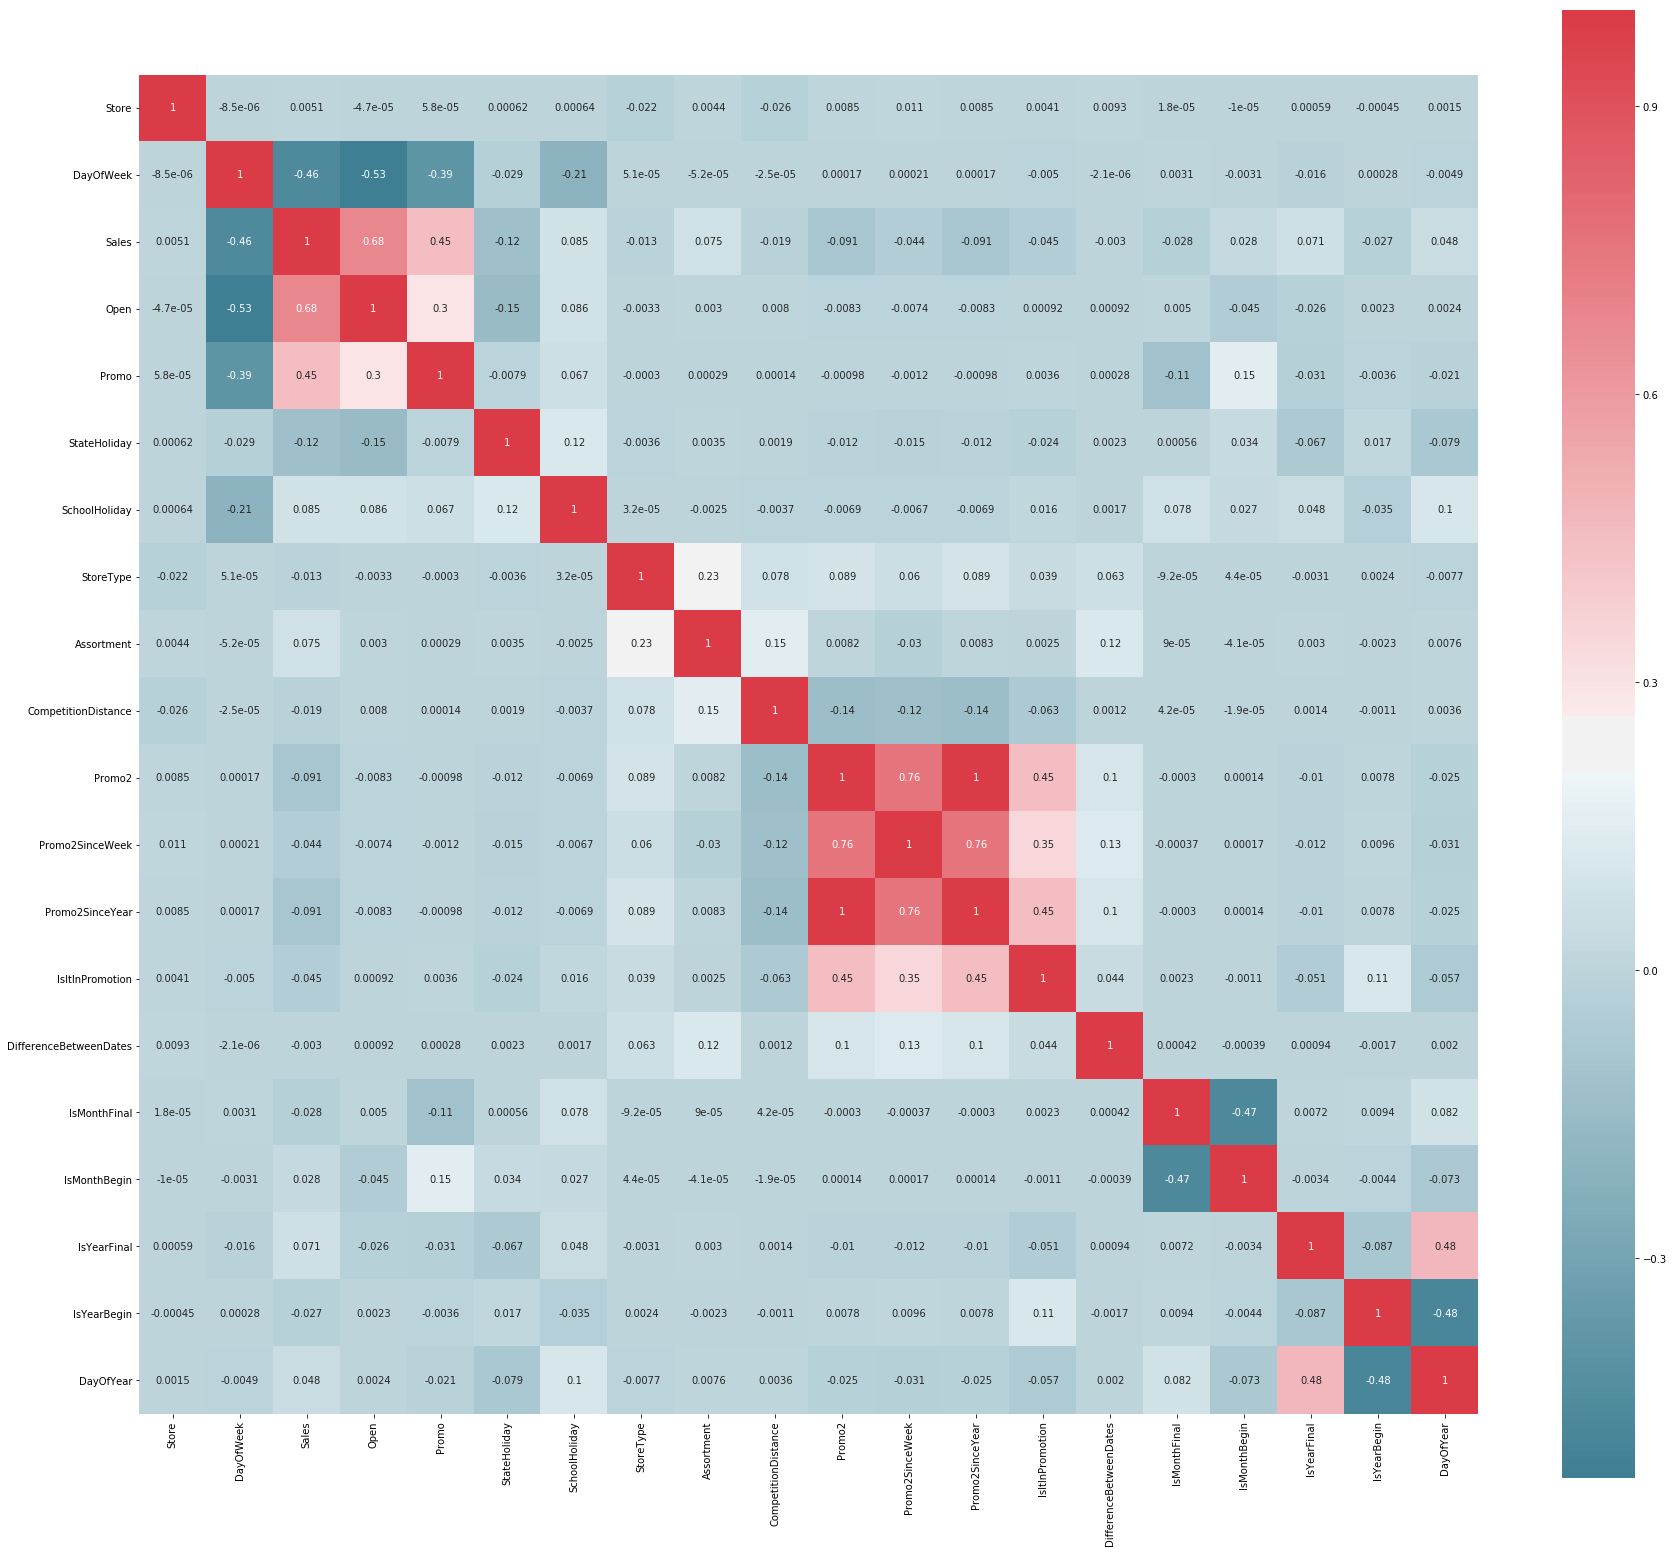

In [47]:
# Ver correlação
corr = df_train.corr()
_ , ax = plt.subplots( figsize =( 30 , 30 ) )
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(corr, cmap = cmap, square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = {'fontsize' : 10 })

In [48]:
# Separar os valores em treino e teste
y = df_train.Sales
x = df_train
x.drop(['Sales', 'PromoInterval'], axis=1, inplace = True)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 101)

In [56]:
y_train_tunning = np.array(pd.DataFrame(y_train)).reshape((-1, ))

In [ ]:
## Tuning parâmetros
loss = ['ls', 'lad', 'huber']
n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
min_samples_leaf = [1, 2, 4, 6, 8]
min_samples_split = [2, 4, 6, 10]
max_features = ['auto', 'sqrt', 'log2', None]


hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features
                      }

model     = GradientBoostingRegressor(random_state = 42)

random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv = 8, 
                               n_iter = 25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, 
                               verbose = 1, 
                               return_train_score = True,
                               random_state=42)

random_cv.fit(X_train.values, y_train_tunning)

print (random_cv.best_score_)
print (random_cv.best_params_)

Fitting 8 folds for each of 25 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


872593    3476
95206     5315
677735    6907
222855    7157
698082    7819
Name: Sales, dtype: int64

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Linear modelo com colunas ['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
Resultados:
MAE: 1773.391653270394 
MSE: 6923669.887507999
RMSE: 2631.2867360871182

Segunda tentativa, com dados não normalizados
MAE: 1779.7226105572372
MSE: 6520572.7667677775
RMSE: 2553.541220886747

In [ ]:
predict_test_file = lm.predict(test_file[colunas])

In [ ]:
predict_test_file[predict_test_file < 0] = predict_test_file[predict_test_file < 0] * (-1)

In [ ]:
# Armazenar o resultado em dataframe:
nome_colunas   = ['Id', 'Sales']
resposta       = pd.DataFrame(columns = nome_colunas)
resposta.Id    = test_file.Id
resposta.Sales = predict_test_file

In [ ]:
# Gravar arquivo
resposta.to_csv('resposta.csv', index = False)